In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from sklearn.preprocessing import MinMaxScaler


In [60]:
def normalize_dataframe(df):
    """
    Normalizes all columns in a pandas DataFrame  using MinMaxScaler.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The normalized DataFrame.
    """
    scaler = MinMaxScaler()
    columns_to_normalize = [col for col in df.columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

In [61]:
def add_up_column(df):
    # Create empty 'up' and 'down' columns
    df['up'] = np.nan
    
    # Loop over the rows (skipping the first row)
    for i in range(0, len(df)-1):
        if df.loc[i+1, '4. close'] > df.loc[i, '4. close']:
            df.loc[i, 'up'] = 1
        else:
            df.loc[i, 'up'] = 0
    return df

In [62]:
def combine_csvs_from_folder(folder_path):
    """
    Combines all CSV files in a folder into a single pandas DataFrame also normalizes before combining them.

    Args:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        A pandas DataFrame containing the concatenated data from all CSV files in the input folder.
    """
    # Use a list comprehension to read all CSV files in the folder into a list of DataFrames.
    dfs = [pd.read_csv(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Use a list comprehension to get the filenames of all CSV files in the folder.
    filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir(folder_path) if f.endswith('.csv')]

    processed_dfs = []
    i = 0
    for df, filename in zip(dfs, filenames):
        # Dont need the date column
        df = df.drop(['date'], axis=1)
        # normalize the dataframes before combining them
        df = normalize_dataframe(df)
        # for the neural network to understand the company name we need to convert it to a number
        df['company'] = i
        i += 1
        df = add_up_column(df)
        processed_dfs.append(df)
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    
    return combined_df

df_full = combine_csvs_from_folder('market_data/merged_data')

df_full.tail()

,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,company,up
54039,0.836382,0.618820,0.098034,0.135600,0.750070,0.20,0.85,0.825,0.349887,0.916590,...,0.775004,0.777489,0.784578,0.780133,0.910496,0.049474,0.0,0.0,10,1.0
54040,0.838415,0.621788,0.096431,0.133143,0.760952,0.15,0.80,0.825,0.345309,0.918329,...,0.781107,0.788813,0.792659,0.788697,0.918977,0.044222,0.0,0.0,10,0.0
54041,0.835553,0.613781,0.102918,0.140160,0.779426,0.10,1.00,0.950,0.347403,0.920624,...,0.793524,0.799283,0.797516,0.785984,0.916290,0.042542,0.0,0.0,10,1.0
54042,0.841508,0.619601,0.112941,0.157132,0.798503,0.05,1.00,0.975,0.353149,0.925806,...,0.791532,0.804615,0.803834,0.806673,0.936779,0.081344,0.0,0.0,10,1.0
54043,0.843942,0.623524,0.128798,0.174423,0.822713,0.00,1.00,1.000,0.347510,0.931589,...,0.806493,0.813785,0.818619,0.812312,0.942363,0.107260,0.0,0.0,10,NaN


In [63]:
#we need this for later
def find_indices_of_test_rows(df):
    indices = []
    for i in range(1, len(df)):
        if np.isnan(df.loc[i, 'up']):
            indices.append(i)
    return indices
idxs = find_indices_of_test_rows(df_full)
print(idxs)


[5786, 11573, 13738, 18320, 24107, 29894, 35681, 38788, 44575, 50362, 54043]


In [64]:
# we should one hot encode the company column
# first we need to change it to a string so we can one hot encode it
df_full['company'] = df_full['company'].astype(str)
df_full = pd.get_dummies(df_full, columns=['company'])

In [65]:
#drop nan rows
df_train = df_full.dropna()

In [66]:
# neural networks require tensors, so we need to convert our dataframes to tensors

def df_to_tensor(df):
    inputs_columns = df.columns[df.columns != 'up']
    inputs = torch.from_numpy(df.loc[:, inputs_columns].values.astype('float32'))
    targets = torch.from_numpy(df.loc[:, ['up']].values.astype('float32'))
    return inputs, targets


inputs, targets = df_to_tensor(df_train)
print(inputs[0])
print(inputs.shape)
print(targets.shape)

tensor([0.1721, 0.5454, 0.1545, 0.1012, 0.5028, 0.9500, 0.2500, 0.1500, 0.0108,
        0.0049, 0.0044, 0.0048, 0.6001, 0.3041, 0.3204, 0.0041, 0.3287, 0.0043,
        0.0770, 0.1221, 0.4935, 0.5869, 0.4913, 0.8474, 0.0045, 1.0000, 0.0041,
        0.4687, 0.4572, 0.5075, 0.5028, 0.4830, 0.5257, 0.0021, 0.0000, 0.4928,
        0.0043, 0.0044, 0.4145, 0.0082, 0.4762, 0.3511, 0.2082, 0.1884, 0.0058,
        0.7284, 0.5345, 0.5344, 0.3204, 0.0051, 0.0044, 0.1780, 0.2642, 0.3207,
        0.1780, 0.2269, 0.0756, 0.0045, 0.0039, 0.0067, 0.0046, 0.7760, 0.3548,
        0.1964, 0.0043, 0.1429, 0.1544, 0.1394, 0.1461, 0.0037, 0.0121, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
torch.Size([54033, 84])
torch.Size([54033, 1])


In [67]:
# making a training and validation dataset

dataset = TensorDataset(inputs, targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [68]:
# pytorch uses dataloaders to load data in batches

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False, num_workers = 0)

In [44]:
# use gpu if avaliable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [45]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 1028),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1028, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_size), 
            nn.Sigmoid()
        )

        

    def forward(self, x):
        x = self.model(x)
        
        return x

# input size is 84 because we have 84 columns in our dataframe
# output size is 1 because we are predicting up=1 or down=0
input_size = 84
output_size = 1
model = NN(input_size, output_size)
model.to(device)

NN(
  (model): Sequential(
    (0): Linear(in_features=84, out_features=1028, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1028, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [46]:
# hyperparameters for training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 500

In [47]:
# training loop
training_losses = []
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #average the loss over all batches
    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)
    if(epoch % 10 == 0 or epoch == 1):
        print(f'epoch: {epoch}, avg_loss: {avg_loss}')

epoch: 1, avg_loss: 0.6931152566386735
epoch: 10, avg_loss: 0.691444044276614
epoch: 20, avg_loss: 0.6899436096491262
epoch: 30, avg_loss: 0.6889459912094946
epoch: 40, avg_loss: 0.6852949756257077
epoch: 50, avg_loss: 0.6821894466736075
epoch: 60, avg_loss: 0.6762832156591664
epoch: 70, avg_loss: 0.6660971689449698
epoch: 80, avg_loss: 0.6566489017601554
epoch: 90, avg_loss: 0.6401795437713605
epoch: 100, avg_loss: 0.6247605395373441
epoch: 110, avg_loss: 0.611155581530668
epoch: 120, avg_loss: 0.5937837963972249
epoch: 130, avg_loss: 0.5807271978111131
epoch: 140, avg_loss: 0.5655726901041982
epoch: 150, avg_loss: 0.5520353136896805
epoch: 160, avg_loss: 0.5346440407260372
epoch: 170, avg_loss: 0.5212247658424062
epoch: 180, avg_loss: 0.5138772544990476
epoch: 190, avg_loss: 0.49938326714732123
epoch: 200, avg_loss: 0.48599688374122546
epoch: 210, avg_loss: 0.4791157997387239
epoch: 220, avg_loss: 0.470273137797137
epoch: 230, avg_loss: 0.4700793945197518
epoch: 240, avg_loss: 0.4505

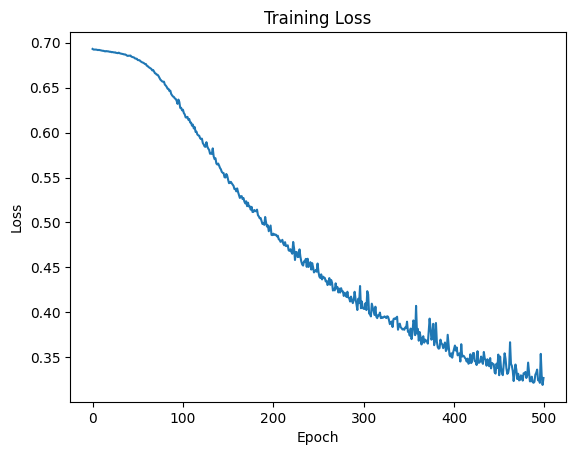

In [48]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [49]:
def validate(model, dataloader, criterion):
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device) # Move data to GPU if available
            outputs = model(inputs)
            loss = criterion(outputs, targets.float()) # BCE loss expects float inputs
            val_loss += loss.item() * inputs.size(0) # Track total validation loss
            
            # Calculate accuracy
            predicted = torch.round(outputs)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(dataloader.dataset)
    accuracy = correct / total
    
    return val_loss, accuracy

val_loss, val_acc = validate(model, val_loader, criterion)
print(f'val_loss: {val_loss}, val_acc: {val_acc}')

val_loss: 0.1715014211449469, val_acc: 0.9444804293513464


In [69]:
# how will visa do tomorrow? > 0.5 = up, < 0.5 = down
inputs, targets = df_to_tensor(df_full)
inputs = inputs.to(device)
print(inputs[len(inputs)-1])
model(inputs[len(inputs)-1])

tensor([0.8439, 0.6235, 0.1288, 0.1744, 0.8227, 0.0000, 1.0000, 1.0000, 0.3475,
        0.9316, 0.9292, 0.9246, 0.6873, 0.7854, 0.6898, 0.9307, 0.3562, 0.9357,
        0.2040, 0.6461, 0.3607, 0.4347, 0.4352, 0.1036, 0.9322, 1.0000, 0.9445,
        0.8403, 0.7648, 0.6639, 0.8227, 0.7697, 0.5621, 0.9630, 0.9986, 0.9220,
        0.9347, 0.9321, 0.2499, 0.1949, 0.7988, 0.0881, 0.9302, 0.5153, 0.4184,
        0.6340, 0.6114, 0.6114, 0.6899, 0.8693, 0.9292, 0.7995, 0.6906, 0.9091,
        0.7995, 1.0000, 0.8597, 0.9133, 0.9364, 0.0972, 0.9234, 0.6640, 0.7015,
        0.9518, 0.9324, 0.8065, 0.8138, 0.8186, 0.8123, 0.9424, 0.1073, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0')


tensor([0.4499], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [70]:
filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir("market_data/merged_data/") if f.endswith('.csv')]

for i, idx in enumerate(idxs):
    print(f"{filenames[i]}: {model(inputs[idx]).item():.2f}")


AAPL: 0.68
AMZN: 1.00
GOOG: 1.00
GOOGL: 1.00
MSFT: 0.53
NVDA: 0.03
PCAR: 0.53
TSLA: 0.01
TSM: 0.80
UNH: 0.97
V: 0.45
